<div style="text-align:center; font-size: 120%">
<h1>Time Spans in Genesis</h1>

<table>
<tr>
<td>
<img src="images/tf.png" 
style="width:250px; height:150px;"
>
</td>
<td>
<img src="images/vuEtcbc.png"
style="width:315px; height:150;"
>
</td>
</tr>
</table>
</div>

**"How do time markers influence the choice of Hebrew verb forms within Genesis clause chains?"**

The goal of this project is to begin, in some small way, to chip away at the question above. We do that looking for "time spans." 

For the purpose of this project, we define time spans as chains of clauses (or clause trees) that are influenced by a time indicator in the first, root clause. After the time spans are constructed, we measure and visualize the data. The last visualization specifically aims at the issue of verb tense and its use amongst certain time indicators. Verb tense in Biblical Hebrew continues to be an area of interest for Hebraists due to its enigmatic use.

In this project, we use the [Text-Fabric](https://github.com/ETCBC/text-fabric) Python package combined with the Biblical Hebrew data from the [Eep Talstra Centre for Bible and Computer](http://www.wi.th.vu.nl).

There are four major steps along the way.

1. Load the Text-Fabric/ETCBC data.
2. Build the time spans.
3. Visualize the time spans by highlighting them in their plain-text form. We use an html document.
4. Gather and analyze statistics including the distribution of time spans, the most common time indicators, and the distribution of verbal tense among the top 10 time phrase indicators.

In [1]:
import collections

## Load Text-Fabric Data

**<span style="color:red">Before moving on to this step,</span>** <br>
please run [Text_Fabric_Tutorial.ipynb](Text_Fabric_Tutorial.ipynb) to set up the package and data on your system.<br>
The api information contained in it is also crucial for understanding the code in this notebook.

In [2]:
from tf.fabric import Fabric

TF_data_dir = '/Users/Cody/github/text-fabric-data/' # specify your TF data directory

text_fabric = Fabric(locations=TF_data_dir,      # instantiate processor
                     modules='Hebrew/etcbc4c')   # module path in TF data dir

This is Text-Fabric 2.3.0
Api reference : https://github.com/ETCBC/text-fabric/wiki/Api
Tutorial      : https://github.com/ETCBC/text-fabric/blob/master/docs/tutorial.ipynb
Data sources  : https://github.com/ETCBC/text-fabric-data
Data docs     : https://etcbc.github.io/text-fabric-data
Shebanq docs  : https://shebanq.ancient-data.org/text
Slack team    : https://shebanq.slack.com/signup
Questions? Ask shebanq@ancient-data.org for an invite to Slack
109 features found and 0 ignored


In [3]:
# load the ETCBC features
tf = text_fabric.load('''
                      book chapter verse 
                      function pdp vt
                      lex lex_utf8 g_word_utf8 gloss
                      mother tab
                    ''')

  0.00s loading features ...
   |     0.01s B book                 from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.01s B chapter              from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.01s B verse                from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.19s B g_word_utf8          from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.17s B lex_utf8             from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.07s B function             from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.13s B pdp                  from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.12s B vt                   from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.13s B lex                  from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.01s B gloss                from /Users/Cody/github/text-fabric-data//Hebrew/etcbc4c
   |     0.19s B moth

In [4]:
# globalize the TF objects:
# cf. explanation in Text_Fabric_Tutorial.ipynb

tf.makeAvailableIn(globals()) 

## Gather ETCBC Data

In this brief section, we perform some preliminary formatting. We build two dictionaries using the `getCorpusClauses()` and `mapDaughterToMother()` functions. The first dictionary provides the clauses from which we will build the time spans. 

The second dictionary contains a necessary mapping from mother clauses to their daughters. In the ETCBC, mother/daughter clauses specify discourse analysis categories between clauses. Mother clauses give rise to daughter clauses based on calculated similarities, conjunctions, etc. Since the ETCBC stores those relationships one way, i.e. `daughter -> mother`, we need to make a reverse mapping: `mother -> list_of_daughters`.


**Text-Fabric API Cheatsheet**
* **`F.otype.s('obj_str')`**
    * generator function that yields specified linguistic object type
* **`F.[feature].v(node_int)`**
    * feature look up function that returns feature string when supplied node
* **`L.u(node_int, otype='obj_str')`**
    * retrieves embedding linguistic object nodes
    * returns as tuple; often indexed due to redundancy
* **`L.d(node_int, otype='obj_str')`**
    * retrieves embedded linguistic object nodes
    * returns tuple; should be iterated through
* **`T.text((node_ints,))`**
    * returns plain text Hebrew, requires iterable of word nodes
    
**Now the formatting...**

In [5]:
def getCorpusClauses(corpus):
    '''
    Returns all the clause nodes in a corpus from the ETCBC database.
    Requires a corpus string argument.
    ex: 'Genesis'
    '''
    # get corpus node
    corpus = next(book for book in F.otype.s('book') # next() gets first & only match
                  if F.book.v(book) == corpus)  
    
    # get all clauses in corpus
    corpus_clauses = L.d(corpus, otype='clause_atom')
    
    return corpus_clauses

In [6]:
def mapDaughterToMother(corpus_clauses):
    '''
     Return reverse mapping of mother/daughter as a dict.

     The ETCBC stores relationships from daughter to mother,
     but we need to reverse it to build the clause chains.
    '''

    mother_daughters = collections.defaultdict(list)

    # append clause to its mother's daughter list
    for clause in corpus_clauses:
        
        daughter_node = clause 
        
        # skip parallel clauses
        if F.tab.v(clause) == 0: 
            continue
        
        # look up the mother node and use it as a key
        # append daughter_node to list value 
        for mother_node in E.mother.f(daughter_node): # edge feature; tuple
            mother_daughters[mother_node].append(daughter_node)

    return mother_daughters

## Build Time Spans

We use 4 functions to construct the time spans:
1. `getTime()` checks for time markers in first, root clauses and returns the time indicating phrase nodes.
2. `climbClauseTree()` recursively moves through the clause tree and adds the clauses from the chain to a list.
3. `getSpanData()` retrieves data from the clause spans for later use. Returns it as a dictionary.
4. `buildTimeSpans()` does it all. It iterates through the corpus clauses and calls `climbClauseTree()` in the process. It returns a list of dictionaries (dicts are formatted with `getSpanData()`^ containing the span data.

In [29]:
def getTime(clause_node):
    '''
    Return the phrase nodes of a time marker if there is one.
    
    The ETCBC stores time phrases as a phrase function feature.
    However, other markers of time are not as obvious.
    This function also checks for less obvious markers.
    '''
    # stores time marker phrase nodes
    time_markers = list()
    
    # ETCBC time-phrase functions
    phrases = list(phrase for phrase in L.d(clause_node, otype='phrase')
                    if F.function.v(phrase) == 'Time')
    time_markers.extend(phrases)
    
    # TO DO: add...
    # substantives with a time sense
    # "when" preposition (ב + infinitive)
    
    return time_markers

In [8]:
def climbClauseTree(root_clause, mother_daughters, span, coverage):
    '''
    Modify a given span list and coverage set recursively
    by climbing a tree (mother_daughters), beginning with root clause.
    
    With mother/daughter clause relations, we have 
    something like a syntax tree, but on a text level.
    This function takes a clause with an initial time phrase and
    recursively iterates through its descendants to gather them.
    
    We add descendants to the span if they don't have 
    an intervening time indicator. They also go into
    the coverage set, so that we don't double-cover 
    them in a later loop.
    '''    
    for daughter in mother_daughters[root_clause]:
        
        # stop if intervening time marker
        if getTime(daughter):
            break

        # add to span and coverage
        span.append(daughter)
        coverage.add(daughter)
        
        # move down the tree with recursive call
        climbClauseTree(daughter, mother_daughters, span, coverage)

In [9]:
def getSpanData(clause_list):
    '''
    Returns a dictionary containing data on a supplied span.
    A span is a list of clause nodes
    and a time marker in the first clause (root).
    Timeless spans do not begin with a time marker.
    '''
    root = clause_list[0] # first clause
    time_markers = getTime(root) # list of time marker phrase nodes
    is_time = True if time_markers else False
    
    span_data = {'time': is_time,
                 'clauses': clause_list,
                 'time_markers': time_markers,
                }
    
    return span_data

    
def buildTimeSpans(corpus_clauses):
    '''
    Gather the time spans by calling climbClauseTree while
    looping over all clauses in the corpus.
    
    Return time spans as list of dictionaries;
    the dictionaries contain keys of data for each span
    
    Skip clauses already in the coverage set.
    Save the time spans in an OrderedDict, keyed by the root clause node
    '''
    mother_daughters = mapDaughterToMother(corpus_clauses)
    time_spans = list()
    coverage = set()
    
    # add timeless spans here:
    timeless_span = list() 
    
    for clause in corpus_clauses:
        
        # build spans for clauses not yet visited that have time marker
        if clause not in coverage and getTime(clause):
            
            # save/reset timeless_span
            if timeless_span:
                time_spans.append(getSpanData(timeless_span))
                timeless_span = list()
            
            # calculate timespan
            span = []
            span.append(clause) # add root clause
            climbClauseTree(clause, mother_daughters, span, coverage) # build the rest
            time_spans.append(getSpanData(span))
            
        elif clause not in coverage and not getTime(clause):
            # add to timeless span
            timeless_span.append(clause)
            
    return time_spans

### Put it all together

Now we make the time spans from which we will produce statistics and visualizations. 

* First we define a corpus with its string representation. 
* Next, we retrieve all its clauses with `getCorpusClauses`. 
* Finally, we feed the `buildTimeSpans` function the clauses.

The result is stored in `spans`, a list of dictionaries which each contain information on its enclosed span.

In [10]:
corpus = 'Genesis'
corpus_clauses = getCorpusClauses(corpus)
spans = buildTimeSpans(corpus_clauses)

#### Sample of the `spans` data:

In [11]:
spans[2:5]

[{'clauses': [514720, 514721], 'time': True, 'time_markers': [605530]},
 {'clauses': [514722, 514723], 'time': True, 'time_markers': [605536]},
 {'clauses': [514724,
   514725,
   514726,
   514727,
   514728,
   514729,
   514730,
   514731,
   514732],
  'time': False,
  'time_markers': []}]

## Create HTML Visualization

Before moving on to basic statistics, it would be nice to visualize what it is exactly that we are measuring ('time spans' can sound a bit vague). One way to do this is to show the plain text representation of the time spans we've found. 

This visualization will highlight all clauses affected by a time marker. The result is an html document that contains the plain Hebrew text (read right-to-left) with highlighting to reveal which clauses belong to time spans.

The colors alternate between blue and green to distinguish separate time spans. The visualization is stored in a seperate [html file](Genesis_timespans.html).

In [12]:
def getClauseLabel(clause_node):
    '''
    Convert a Text-Fabric node integer into a clean label.
    return a label: "book.chapter.verse.NthClause"
    '''
    # find book, chapter, verse nodes containing given clause
    book_node = L.u(clause_node, otype='book')[0]   
    chapter_node = L.u(clause_node, otype='chapter')[0] 
    verse_node = L.u(clause_node, otype='verse')[0]  
    
    # convert section nodes to their string representations
    book = F.book.v(book_node)
    chapter = F.chapter.v(chapter_node)
    verse = F.verse.v(verse_node)
    
    # find which clause number this clause node is
    verse_clauses = L.d(verse_node, otype='clause_atom') # all verse's clauses
    clause_num = verse_clauses.index(clause_node) + 1    # N'th clause; +1 for aesthetics
    
    # format into label and return string
    clause_label = '{book}.{chap}.{ver}.{clause}'.format(book=book,
                                                         chap=chapter,
                                                         ver=verse,
                                                         clause=clause_num)
    return clause_label

In [13]:
import itertools

def writeHTMLDoc(all_spans, title):
    '''
    Write HTML visualization.
    '''
    
    # open html templates: 
    with open('HTMLTemplates/doc.txt') as doc:
        doc_template = doc.read()
    with open('HTMLTemplates/data.txt') as data:
        data_template = data.read().replace('\n','').replace('\t','')

    # html chars/formats 
    indent = '&nbsp;&nbsp;&nbsp;&nbsp;'
    colors = itertools.cycle(('#addfff','#a3e2a1'))

    # compile html code to this str:
    html_body = ''

    for span in all_spans:
        
        color = next(colors) if span['time'] else '' # assign shading
        
        for clause in span['clauses']:
            label = indent + getClauseLabel(clause)
            indentation = F.tab.v(clause) * indent # etcbc clause relation
            
            # assemble plain-text representation:
            words = L.d(clause, otype='word')
            text = T.text(words) + indentation
            
            # fill template; add to html code
            html_body += data_template.format(color=color,
                                                 text=text,
                                                 label=label)
    
    # complete html code         
    html_doc = doc_template.format(data=html_body,
                                   title=title)
    return html_doc

### Put it all together:

Now we create the final product by
* giving it a title formatted by corpus name
* calling the `writeHTMLDoc` function with the data and title
* writing the data to the html file with the corpus formatted into its name

In [14]:
title = 'Time Spans in {corpus}'.format(corpus=corpus)

time_span_visualization = writeHTMLDoc(spans, title)

with open('{}_timespans.html'.format(corpus), 'w') as htmlfile:
    htmlfile.write(time_span_visualization)

#### See the final product here!

** [Time Span Visualization](https://cdn.rawgit.com/codykingham/tfNotebooks/fb422cbf/timeSpans/Genesis_timespans.html) **

# Statistics

Now that we've gathered and visually examined the time spans, we can begin to answer some basic questions:

* What kinds of time indicators were found? 
* How are time indicators distributed across the corpus? 
* How are verb tenses influenced by the time indicators?

## Time Marker Inventory

We pull the time indicators saved to each time span, and save their plain text representation to an inventory.

In [15]:
def HebEngLabel(phrase_node):
    '''
    Returns concatonated Hebrew txt/English gloss of a time phrase node.
    English for my non-Hebrew reading friends :)
    '''
    # get word nodes
    word_nodes = L.d(phrase_node, otype='word')
    
    # convert to lexemes
    lexemes = ((L.u(word, otype='lex')[0] 
                    for word in word_nodes))
    
    # concatenate words
    english_gloss = ' '.join(F.gloss.v(lex) for lex in lexemes)
    hebrew_words = T.text(word_nodes)
    
    label = hebrew_words + ', ' + english_gloss
    
    return label

#### Now make the inventory...

First we make a new time spans list that contains ONLY spans with time indicators...

In [16]:
# get clauses with time spans
time_spans = list(span for span in spans 
                      if span['time'])

Now we create the inventory...

In [17]:
# map time-span label to its span data
# to be used later...
marker_to_span = collections.defaultdict(list)

# build the inventory...
timespan_inventory = collections.Counter()

for span in time_spans:
        
    # create label to count
    time_marker = ' ' .join(HebEngLabel(phrase) for phrase 
                                in span['time_markers'])
    # count it
    timespan_inventory[time_marker] += 1
    # keep its span
    marker_to_span[time_marker].append(span)

#### Total Time Markers:

In [18]:
print('There are {} DIFFERENT time markers in {}.'.format(len(timespan_inventory), corpus))

There are 220 DIFFERENT time markers in Genesis.


### Basic Time Marker Stats

There's quite a lot of variation. Let's see what kinds of time markers the code found...

We create a data frame using Pandas in order to display a simple table. The table only contains time markers with an occurrence greater than 1.

In [19]:
import pandas as pd

# every marker with > 1 occurrence
top_markers = list(marker for marker 
                       in timespan_inventory.most_common() 
                       if marker[1] > 1)

markers_df = pd.DataFrame(top_markers, columns=['Markers','Count'])

In [20]:
markers_df

,Markers,Count
0,"בַּבֹּ֗קֶר , in the morning",4
1,"שְׁלֹשִׁ֣ים שָׁנָ֑ה , three year",3
2,"הַלָּ֑יְלָה , the night",3
3,"אַחַר֙ הַדְּבָרִ֣ים הָאֵ֔לֶּה , after the word...",3
4,"הַיֹּ֔ום , the day",3
5,"בַבֹּ֔קֶר , in the morning",3
6,"עַתָּה֙ , now",3
7,"בַּיֹּ֣ום הַשְּׁבִיעִ֔י , in the day the seventh",2
8,"הַיֹּ֗ום , the day",2
9,"בְּיֹ֖ום , in day",2


The data shows that much of the variation is due to differences in the noun object. In a future project, we could seek to separate content terms from their modifiers in order to get better time indicator groups.

## Distribution of Time Marked Clauses

How are time indicators distributed throughout the corpus?

First we look across the corpus. We will measure the number of clauses under the governance of an explicit time indicator and examine that per chapter. We present the results in a graph.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style='whitegrid')

In [22]:
def getChapter(node):
    '''
    Return the chapter number of a supplied node.
    Requires TF node contained within a chapter unit.
    '''
    chapter_node = L.u(node, otype='chapter')[0]
    chapter = F.chapter.v(chapter_node)
    return chapter

# lists of span clauses
span_clauses = (span['clauses'] for span in time_spans)

# holds the counts
ch_counts = collections.Counter()

# Based on ETCBC data structure,
# it is expected that spans don't contain > 1 chapter,
# due to the encoding process.
# So we harvest chapter from 1st clause only, span[0]

for span in span_clauses:
    chapter = getChapter(span[0])
    
    # add any missing chapters to the count with 0 clauses
    if chapter - 1 not in ch_counts:
        ch_counts[chapter-1] = 0
    
    len_clauses = len(span)
    ch_counts[chapter] += len_clauses 

In [23]:
# get x and y axes for plot
clause_counts = list(count for count in ch_counts.values())
chapters = list(chapter for chapter in ch_counts.keys())

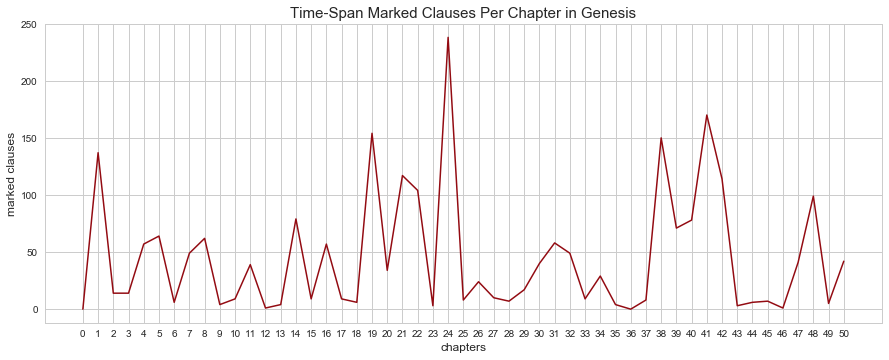

In [24]:
# configure plot
plt.figure(figsize=(15,5.5)) # plot size
plt.xticks(list(ch for ch in chapters)) # tick marks 
plt.xlabel('chapters', fontsize=12)
plt.ylabel('marked clauses', fontsize=12)
plt.title(s='Time-Span Marked Clauses Per Chapter in {}'.format(corpus), fontsize=15)

chapter_plot = plt.plot(chapters, # x
                        clause_counts, # y
                        linewidth=1.5, 
                        color='#930b12')

There are some interesting things happening between chapters 25 and 37, where the average number of marked clauses appears lower. Likewise with chapters 18-24, where the average appears higher.


What, then, is the overall average number of clauses per chapter that are marked with a governing time marker?

In [25]:
import statistics as stats

# average marked clauses per chapter
avg_clauses = stats.mean(ch_counts.values()) 
avg_clauses = round(avg_clauses, 2)

print('{} average clauses under an explicit time marker per chapter'.format(avg_clauses))

45.49 average clauses under an explicit time marker per chapter


# Verb Use Among the Top 10 Most Common Markers 

Finally, we count the kinds of verb tenses found among the top 5 most common time markers in the corpus. We return to the `marker_to_span` dict created when we made the time markers inventory.

In [26]:
# gather top 10 most common time markers as keys
# values are Counter objects in which verbs can be counted

top_ten = dict((label[0], collections.Counter()) # tuple
                       for label 
                       in timespan_inventory.most_common()[:10]) # top 10

# create the counts 
# use marker_to_span to pull clause data
for time_marker in top_ten:
    
    # all time spans with that marker
    spans = marker_to_span[time_marker]

    # find the clause, then the verb(s) and count the tenses
    for span in spans:
        
        clauses = span['clauses'] # pull span clauses
        
        # find verb(s)
        for clause in clauses: 
            verbs = (word for word in L.d(clause, otype='word') # get verbs
                         if F.pdp.v(word) == 'verb') # word must be verb
            
            tenses = tuple(F.vt.v(verb) for verb in verbs) # get vb tenses
            top_ten[time_marker]['total'] += len(tenses) # add to total
            top_ten[time_marker].update(tenses) # update count


top_ten = collections.OrderedDict(top_ten) # preserve order
    
# sample:
list(top_ten.items())[:2]

[('בַּבֹּ֗קֶר , in the morning',
  Counter({'impf': 10,
           'impv': 1,
           'infc': 1,
           'perf': 9,
           'total': 76,
           'wayq': 55})),
 ('שְׁלֹשִׁ֣ים שָׁנָ֑ה , three year',
  Counter({'infc': 3, 'perf': 1, 'total': 12, 'wayq': 8}))]

### Now we create the visualization! 

For each of the top 10 time markers, we make a pie chart. Each slice of the pie will represent a verb tense. Each verb tense is presented as a proportion of the total tenses in the time span. To keep the charts close together, we use a subplot...

In [27]:
def getPercent(amount, total):
    '''
    Return a simple percentage rounded to nearest 2.
    '''
    return round((amount/total)*100,2)

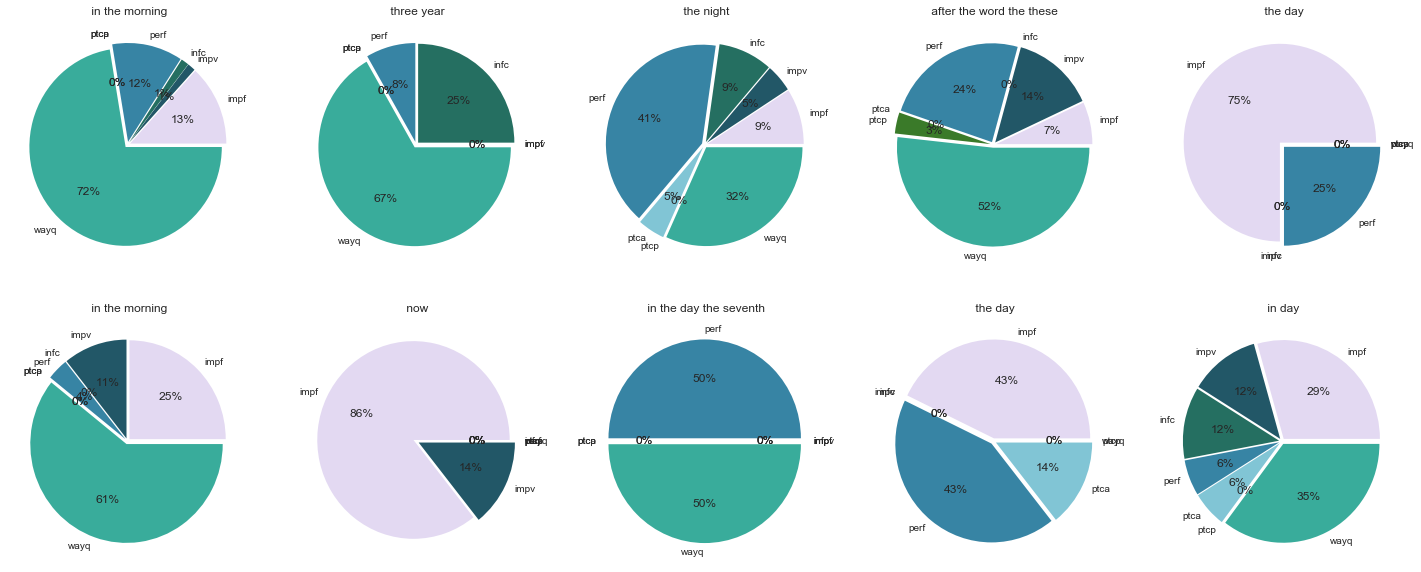

In [28]:
# get all verb tenses for labels
all_tenses = sorted(set(tense for marker in top_ten
                           for tense in top_ten[marker]
                               if tense != 'total'))

# separator value for pie chart
explode = (list(0.03 for i in 
                    range(len(all_tenses))
                        ))

# hex codes for pie chart
colors = ('#e3d9f2','#225767', 
          '#256f61','#3784a4',
          '#81c5d5','#3a7a29',
          '#39ac9b')

# rows / columns of subplot
nrows, ncols = 2, 5 
    
fig = plt.figure() # initialize plt fig

# create the subplot pie charts for each of the 10 top markers
# enumerate to assign chart location in the subplot
for i, marker in enumerate(top_ten):
    
    i += 1 # subplot grid location
    data = top_ten[marker] # get verb data

    # fill in any missing tenses
    tense_percentages = list()
    for tense in all_tenses:
        tense_total = data.get(tense, 0) # return 0 if not present
        tense_percent = getPercent(tense_total, data['total']) \
                            if tense_total != 0 else 0 # avoid zero error on percentage calc.
        tense_percentages.append(tense_percent)
    
    # build subplots
    fig.add_subplot(nrows, ncols, i)
 
    # set dimensions
    fig.set_figheight(10)
    fig.set_figwidth(25)
    
    plt.pie(tense_percentages, 
            colors=colors,
            explode=explode, # separate slices
            labels=all_tenses, 
            autopct='%.0f%%')
    plt.title(marker.split(',')[1]) # title with English gloss

The lavender slices represent the 'imperfect' verb ("yiqtol"), the typical verb of discourse, while the aquamarine slices represent the 'preterite' ("wayyiqtol"), the typical verb of narrative.

Already an interesting pattern may be developing with the time indicators "day," and "now." "Day" is included more than once, it seems, because of a slight difference in vocalization. It may be useful in the future to weed out these sorts of differences. But for now, the tendency of these time phrases to line up with the "imperfect" verb form shows some promising possibilities for future analysis.

## Conclusions

Not all time indicators are yet accounted for in the time spans builder. For example, infinitives with certain prepositions (ex: ב + infinitive), or substantives with a time sense, need to be accounted for in the `getTime()` function to account for more possibilities. For an actual example, see [Gen. 2.4.2 in the time spans visualization](https://cdn.rawgit.com/codykingham/tfNotebooks/fb422cbf/timeSpans/Genesis_timespans.html) where the phrase בהבראם ("when they were made") occurs but is not detected.

Another adjustment to be made in the future: the time phrases ought to be grouped together by similar construction, but in some cases, the difference in substantive should not be accounted for. 

Questions for further investigation:
1. Does ביום ("in the day/time") occur most frequently alongside the yiqtol and other discourse verbs elsewhere in Hebrew narratives as it does here? What about within the time indicators that occur less than the top ten?
2. What exactly constitutes the semantic information of a "time indicator" in a given substantive, and can it be automatically generated from the text through certain patterns? 